In [1]:
import pandas as pd
import math
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy
from sklearn import mixture

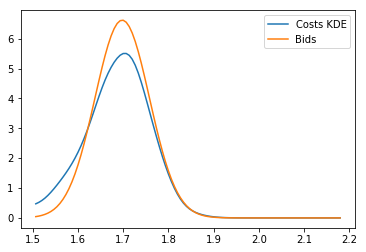

In [2]:
#draw data
n=2000

bids = np.concatenate((np.random.normal(loc=1.7, scale=0.06, size=int(.8*n)), 
                      np.random.normal(loc=1.9, scale=0.07, size=int(.2*n))))

#fit mixture model
g = mixture.GaussianMixture(n_components=2)
g.fit(bids.reshape(n,1))
ind =  np.argmin(g.means_, axis=0)[0]


#print values given competitive distribution
i = 7.
g1 = lambda b: scipy.stats.norm.pdf(b,g.means_[ind,0],g.covariances_[ind,0]**.5)
G1 = lambda b: scipy.stats.norm.cdf(b,g.means_[ind,0],g.covariances_[ind,0]**.5)

values = bids - (1-G1(bids))/g1(bids)/(i-1)

#KDE_weighted
q = g.predict_proba(bids.reshape(n,1))[:,ind]
kde = sm.nonparametric.KDEUnivariate(values)

kde.fit(weights=q, fft=False)
plt.plot(kde.support[1.5<kde.support], kde.density[1.5<kde.support], label='Costs KDE')
plt.plot(kde.support[1.5<kde.support], g1(kde.support[1.5<kde.support]), label='Bids')

plt.legend()
plt.show()

In [3]:
def interp_cdf(x,kde):
    """apparantly this isn't in statsmodels, want to make sure this is smooth"""
    #make sure this is safe
    if kde.support.min() >= x:
        return np.array([0])
    if kde.support.max() <= x:
        return np.array([1])
        
    x_left = kde.support[kde.support < x][-1]
    x_right = kde.support[kde.support > x][0]
    
    cdf_left = kde.cdf[kde.support < x][-1]
    cdf_right = kde.cdf[kde.support > x][0]
    
    return cdf_left + (x-x_left)*(cdf_right-cdf_left)/(x_right-x_left)
 
print interp_cdf(7,kde)

[1]


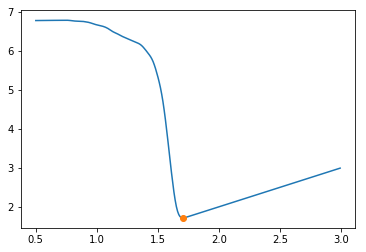

In [4]:
def pi_u(p, vs, i, kde):
    """upper bound for costs"""
    pi = []
    for q in p:
        q_cdf = interp_cdf(np.array([q]),kde)
        pi_q = vs*(1-q_cdf)**i + q*(1-(1-q_cdf)**i)
        pi = np.concatenate((pi,pi_q))   
    return pi


def pi_opt(vs, i, kde):
    """argmax of lower bound"""
    obj = lambda p: pi_u(p, vs, i, kde)
    result = scipy.optimize.differential_evolution(obj,
                                [(kde.support.min(),kde.support.max())])
    return result.x, obj(result.x)

    
support = np.arange(.5,3,.01)

ub = pi_u(support, 7, i, kde)
plt.plot(support, ub, label='Upper Bound')

argmax_ub, max_ub  = pi_opt(7, i, kde)
plt.plot(argmax_ub, max_ub, label='LB Max',marker='o')

plt.show()

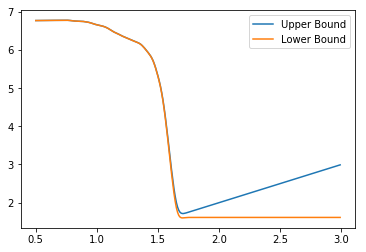

In [5]:
def pi_l(p, vs, i, kde):
    """lower bound for costs"""
    # integrand = i*(i-1)*(1-kde.cdf)*kde.support*kde.cdf**(i-2)*kde.density
    integrand = i*(i-1)*kde.cdf*kde.support*(1-kde.cdf)**(i-2)*kde.density
    integrand = scipy.interpolate.BSpline(kde.support, integrand, 1)
    pi = []
    for q in p:
        q_cdf = interp_cdf(np.array([q]),kde)
        baseline = vs*(1-q_cdf)**i + i*q*q_cdf*(1-q_cdf)**(i-1)
        integral = integrand.integrate(kde.support.min(),q)
        pi = np.concatenate((pi, baseline + integral))    
    return pi


lb = pi_l(support, 7, i, kde)
plt.plot(support, ub, label='Upper Bound')
plt.plot(support, lb, label='Lower Bound')
plt.legend()
plt.show()

[1.70295489]


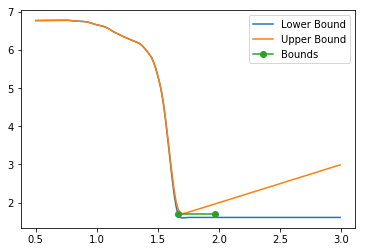

In [6]:
def pi_est(vs, i, kde):
    """calculate the """
    argmin, minim = pi_opt( vs, i, kde)
    print argmin
    obj = lambda p: (pi_l(p, vs, i, kde) - minim)**2
    
    #left bound
    bnds1 = [(kde.support.min(), argmin)]
    result1 = scipy.optimize.differential_evolution(obj,  bounds=bnds1 )
    
    #right bound
    bnds2 = [(argmin,kde.support.max())]
    result2 = scipy.optimize.differential_evolution(obj,   bounds=bnds2 )
    
    return np.array([result1.x,result2.x])


plt.plot(support, lb, label='Lower Bound')
plt.plot(support, ub, label='Upper Bound')

#calculate bounds
p_bnds = pi_est(7, i, kde)
plt.plot(p_bnds, np.tile(max_ub,2), label='Bounds',marker='o')
plt.legend()
plt.show()